In [9]:
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt
import os
import os.path


In [10]:
# extract solution from xubo solution file in the format
# (result: df, valids: df, success_rate: percentage)
def read_xubo_solution(file='2x7', N=14, lamda_path = ''):

    energy_file = open(f'energies/{lamda_path}{str(N)}/{file}', 'r')
    energy_lines = [line[:-1] for line in energy_file.readlines()]

    file = re.findall('.*(?<=.ising)', file)[0]
    source_file = open(f'IsingTerms/{lamda_path}{str(N)}/{file}', 'r')
    source_lines = [line[:-1] for line in source_file.readlines()]

    # extract values from source file to generate pd df later
    offset = float(re.findall('\S+$',source_lines[1])[0])
    qubit_dict = re.findall('{.+}',source_lines[2])[0]
    qubit_dict = ast.literal_eval(qubit_dict)

    energy_lines = [line.split('\t') for line in energy_lines[17:]]
    # store in the format [qubits, energy]
    # has to be turned around so it fits qubit mapping
    energy_lines = [list(line[1])[::-1] + [line[0]] for line in energy_lines]
    # extend and clean df
    result = pd.DataFrame.from_records(data=energy_lines, columns = list(qubit_dict.keys()) + ['energy'])
    result = result.reindex(sorted(result.columns), axis=1)
    result['a'] = result.filter(regex='^p[0-9]+$').apply(lambda row: int(''.join(['1']+list(row.values.astype(str))+['1'])[::-1],2), axis=1) 
    result['b'] = result.filter(regex='^q[0-9]+$').apply(lambda row: int(''.join(['1']+list(row.values.astype(str))+['1'])[::-1],2), axis=1)
    result['valid'] = result['a'] * result['b'] == int(N)
    valid = result[(result['valid'] == True)]
    result['energy'] = result['energy'].astype(float)
    result['energy'] += offset
    valids = result[(result['valid'] == True)]
    success_rate = 0 if valids.empty else len(valids)/ len(result) *100
    energy_file.close()
    return ((result, valids, success_rate))

In [11]:
results = {}
result_dfs = {}
N = 91
Ns = [91,143,437,493]




for N in Ns:
    lamda_path = "dynamic/"
    base_path = os.path.join(os.getcwd(), 'energies',lamda_path, str(N))
    files = os.listdir(base_path)
    xubo_solutions = {}
    df_dict ={
        'N': [],
        'lamda':[],
        'min_energy': [],
        'min_energy_is_solution':[]
    }


    for i,file in enumerate(files):  
        lamda = re.findall('(?<=lamda_0\.)\d+', file)
        if not lamda:
            continue
        lamda = int(lamda[0])
    #    file = os.path.join(base_path, file)
        result,_,_ = read_xubo_solution(file=file, N=N, lamda_path=lamda_path)
        results[N] = result
       # if lamda == 4:
        #    print(result[['p0','q0','q1','c0','c1','c2','c3','t0','t1','a','b', 'energy', 'valid']].sort_values(by='energy').head(4))

        df_dict['N'].append(N)
        df_dict['lamda'].append(lamda)
        df_dict['min_energy'].append(result.head(1).loc[0,'energy'])
        df_dict['min_energy_is_solution'].append(result.head(1).loc[0,'valid'])

        xubo_solutions[lamda] = (result.head(10))

    result_dfs[N] = pd.DataFrame(df_dict)



    xubo_solutions = dict(sorted(xubo_solutions.items()))
    #print(result_df)


In [12]:
for N, df in result_dfs.items():
    result_dfs[N] =df.sort_values(by='lamda') 
    print(df.sort_values(by='lamda'))

     N  lamda    min_energy  min_energy_is_solution
2   91      1 -5.200000e+00                   False
0   91      2  0.000000e+00                    True
6   91      3  1.421085e-14                    True
5   91      4  0.000000e+00                    True
8   91      5  0.000000e+00                    True
11  91      6  0.000000e+00                    True
1   91      7  1.421085e-14                    True
3   91      8 -1.421085e-14                    True
4   91      9  0.000000e+00                    True
9   91     32  0.000000e+00                    True
10  91     33  0.000000e+00                    True
7   91     34  1.421085e-14                    True
      N  lamda    min_energy  min_energy_is_solution
9   143      1 -2.500000e+01                   False
6   143      2 -1.060000e+01                   False
0   143      3 -4.400000e+00                   False
7   143      4 -2.842171e-14                    True
1   143      5  0.000000e+00                    True
11  14

In [22]:
print(result_dfs[493].head(10).to_latex())

\begin{tabular}{lrrrr}
\toprule
 & N & lamda & min_energy & min_energy_is_solution \\
\midrule
7 & 493 & 1 & -199.000000 & False \\
2 & 493 & 2 & -147.000000 & False \\
21 & 493 & 3 & -103.000000 & False \\
15 & 493 & 4 & -67.000000 & False \\
20 & 493 & 5 & -51.000000 & False \\
13 & 493 & 6 & -35.000000 & False \\
27 & 493 & 7 & -19.000000 & False \\
16 & 493 & 8 & -10.000000 & False \\
25 & 493 & 9 & -2.000000 & False \\
6 & 493 & 10 & 0.000000 & True \\
\bottomrule
\end{tabular}



In [42]:
print(xubo_solutions[11].head(1))

  c0 c1 c2 c3  energy p0 p1 p2 q0 q1  ... t2 t3 t4 t5 t6 t7 t8   a   b valid
0  0  0  0  0     0.0  0  1  1  0  0  ...  0  0  0  0  0  0  0  29  17  True

[1 rows x 23 columns]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


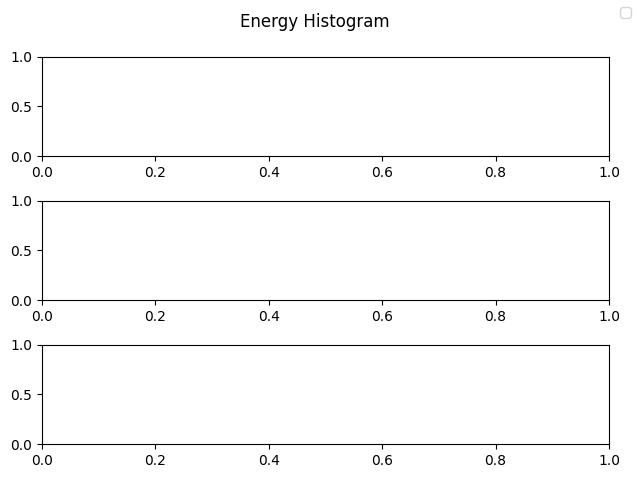

In [35]:
fig, (r_ax, v_ax, r_low_ax) = plt.subplots(3,1)
fig.suptitle("Energy Histogram")
for k,(result, valids, success_rate) in results.items():
    if not valids.empty:
        print(f'Number of valid entries should equal 2**(n_qubits - (len_a + len_b)) [* 2 if len_a == len_b]: {len(valids)}')
    
        energy_count_valids = valids[['energy']].value_counts(sort=False)
        energy_count_result = result[['energy']].value_counts(sort=False)
        # idk why but index is multiseries ???????
        # so we have to transform to normal
        v_keys = [key[0] for key in energy_count_valids.index]
        v_ax.plot(v_keys, energy_count_valids.values, label=k)
        v_ax.set_title("Only valids")

        # same here
        r_keys = [key[0] for key in energy_count_result.index]
        r_ax.plot(r_keys, energy_count_result.values)
        r_ax.set_title("All entries")

        # same here
        r_keys = [key[0] for key in energy_count_result.index]
        r_low_ax.plot(r_keys[:10], energy_count_result.values[:10], marker='o')
        r_low_ax.set_title("Low energy states")
        r_low_ax.set_yscale('log')
fig.legend()
fig.tight_layout()


Makes sense if you consider that there are 4 times more possible solutions for 5x7

Question:
- success rate / number of possible solutions if we generate bigger multiplication circuit

In [ ]:
i